In [2]:
%matplotlib inline
import numpy as np
from copy import copy
import math, random
import matplotlib.pyplot as plt 
from matplotlib.patches import Ellipse

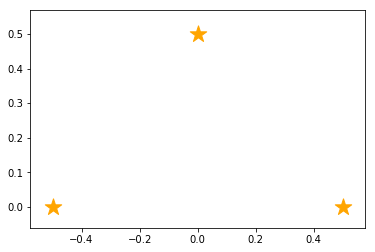

In [3]:
actual_landmarks = [np.array([-0.5,0.0]),np.array([0.5,0.0]),np.array([0.0,0.5])]

def draw_landmarks(landmarks):
    xs = [ e[0] for e in landmarks]
    ys = [ e[1] for e in landmarks]
    plt.scatter(xs,ys,s=300,marker="*",label="landmarks",color="orange")
    
draw_landmarks(actual_landmarks)

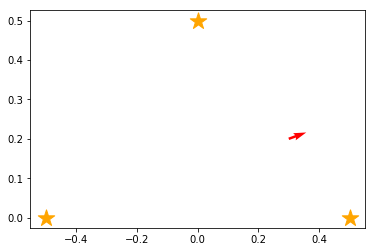

In [4]:
actual_x = np.array([0.3,0.2,math.pi*20.0/180])

def draw_robot(pose):
    plt.quiver([pose[0]],[pose[1]],[math.cos(pose[2])],[math.sin(pose[2])],color="red",label="actual robot motion")
    
draw_robot(actual_x)
draw_landmarks(actual_landmarks)

In [5]:
def relative_landmark_pos(pose,landmark):
    x,y,theta = pose
    lx,ly = landmark
    distance = math.sqrt((x -lx)**2 + (y-ly)**2)
    direction = math.atan2(ly-y, lx-x) - theta
    
    return (distance, direction,lx,ly)

In [6]:
measurements = [ relative_landmark_pos(actual_x,e) for e in actual_landmarks]
print(measurements)

[(0.8246211251235323, -3.2456798408617948, -0.5, 0.0), (0.28284271247461906, -1.1344640137963142, 0.5, 0.0), (0.4242640687119285, 2.0071286397934789, 0.0, 0.5)]


In [7]:
def draw_observation(pose,  measurement):
    x,y,theta = pose
    distance, direction,lx,ly = measurement
    lx = distance*math.cos(theta + direction) + x
    ly = distance*math.sin(theta + direction) + y
    plt.plot([pose[0],  lx],[pose[1],  ly],color="pink")
    
def draw_observations(pose,  measurements):
    for m in measurements:
        draw_observation(pose, m)

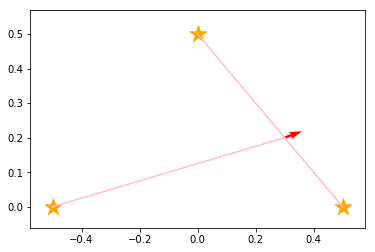

In [8]:
draw_landmarks(actual_landmarks)
draw_robot(actual_x)
draw_observations(actual_x,measurements)

In [9]:
def observation(pose, landmark):
    actual_distance,actual_direction,lx,ly = relative_landmark_pos(pose,landmark)
    
    if (math.cos(actual_direction) < 0.0):
        return None
    
    measured_distance = random.gauss(actual_distance,actual_distance*0.1)  
    measured_direction = random.gauss(actual_direction,5.0/180.0*math.pi)  
    
    return (measured_distance, measured_direction,lx,ly)

def observations(pose,landmarks):
    return filter(lambda x: x != None, [ observation(pose,e) for e in landmarks])

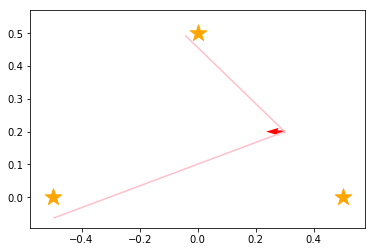

In [10]:
actual_x = np.array([0.3,0.2,math.pi*180.0/180])
measurements = observations(actual_x, actual_landmarks)

draw_landmarks(actual_landmarks)
draw_robot(actual_x)
draw_observations(actual_x, measurements)

In [11]:
class Particle:
    def __init__(self,w):
        self.pose = np.array([0.0,0.0,0.0])
        self.weight = w
    
    def __repr__(self):
        return "pose: " + str(self.pose) + " weight: " + str(self.weight)
        

def f(x_old,u):
    pos_x, pos_y, pos_theta = x_old
    act_fw, act_rot = u
    
    act_fw = random.gauss(act_fw,act_fw/10)
    dir_error = random.gauss(0.0, math.pi / 180.0 * 3.0)
    act_rot = random.gauss(act_rot,act_rot/10)
    
    pos_x += act_fw * math.cos(pos_theta + dir_error)
    pos_y += act_fw * math.sin(pos_theta + dir_error)
    pos_theta += act_rot
    
    return np.array([pos_x,pos_y,pos_theta])

def draw(pose,particles):    
    fig = plt.figure(i,figsize=(8, 8))
    sp = fig.add_subplot(111, aspect='equal')
    sp.set_xlim(-1.0,1.0)
    sp.set_ylim(-0.5,1.5)
    
    xs = [e.pose[0] for e in particles]
    ys = [e.pose[1] for e in particles]
    vxs = [math.cos(e.pose[2])*e.weight for e in particles]
    vys = [math.sin(e.pose[2])*e.weight for e in particles]
    plt.quiver(xs,ys,vxs,vys,color="blue",label="particles")
    
    plt.quiver([pose[0]],[pose[1]],[math.cos(pose[2])],[math.sin(pose[2])],color="red",label="actual robot motion")

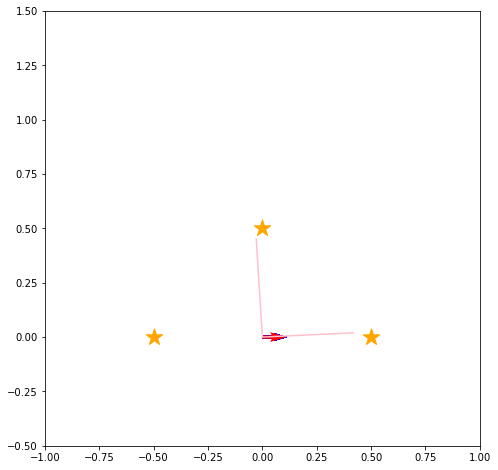

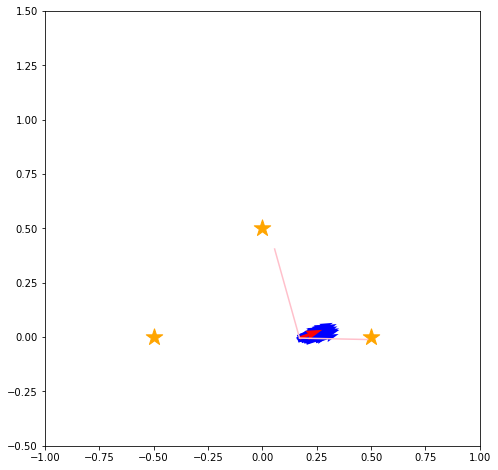

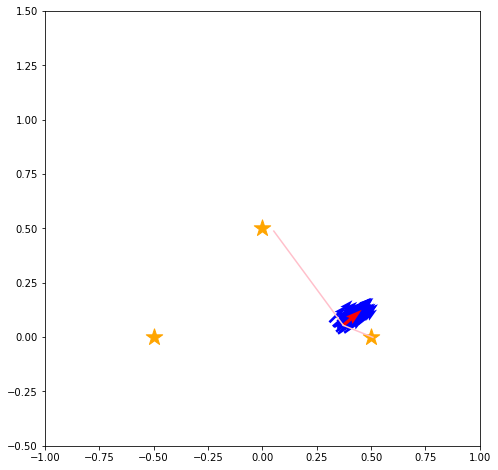

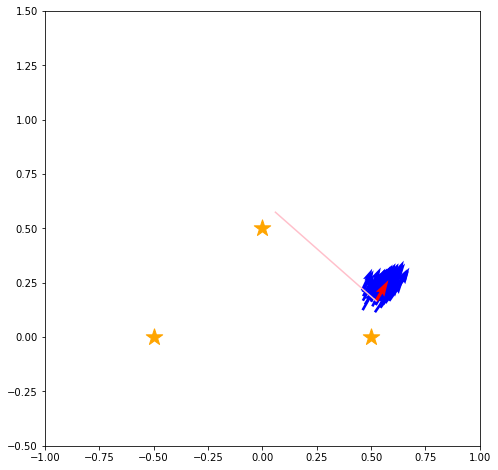

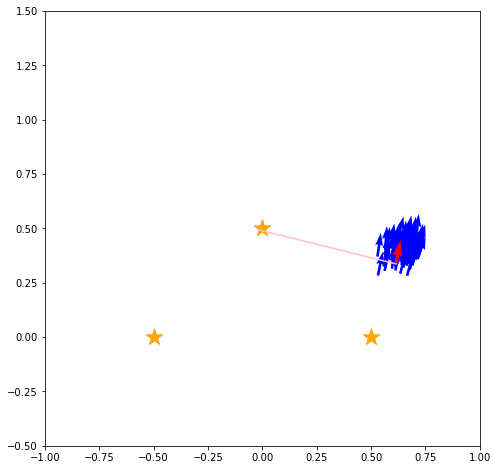

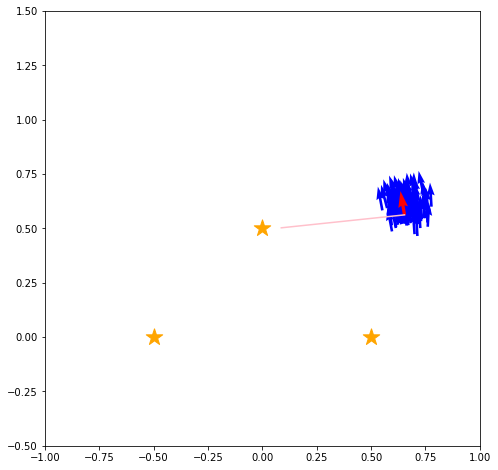

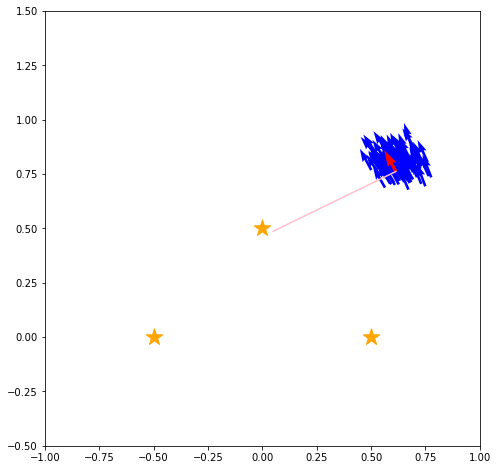

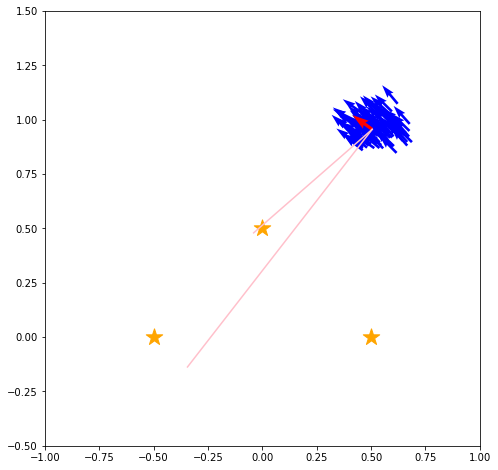

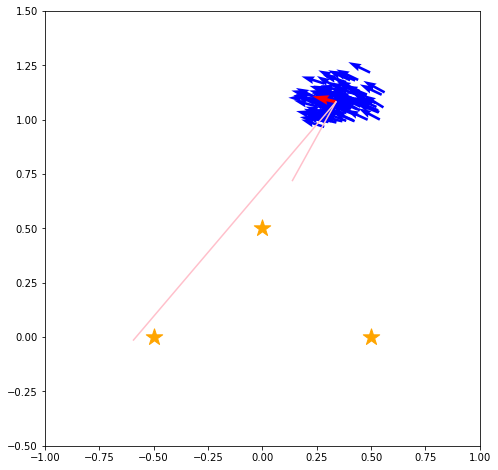

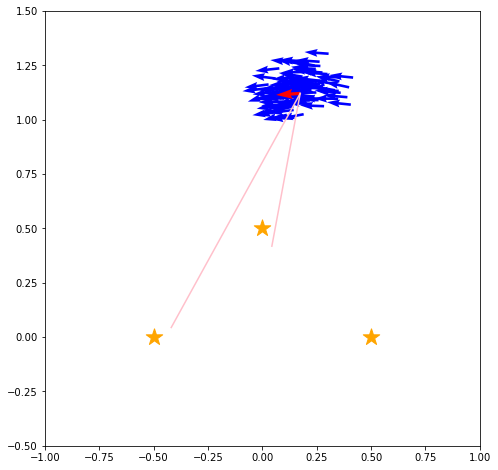

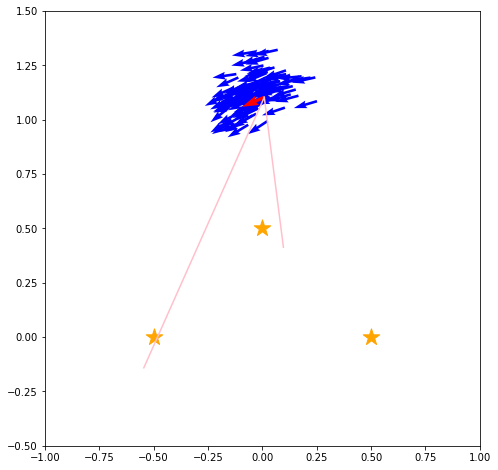

In [12]:
actual_x = np.array([0.0,0.0,0.0])
particles = [Particle(1.0/100) for i in range(100)]
u = np.array([0.2,math.pi / 180.0 * 20])

import copy

path = [actual_x]
particle_path = [copy.deepcopy(particles)]
measurementss = [observations(actual_x, actual_landmarks)]
for i in range(10):
    actual_x = f(actual_x,u)
    path.append(actual_x)
    measurementss.append(observations(actual_x,actual_landmarks))

    for p in particles:
        p.pose = f(p.pose,u)
    particle_path.append(copy.deepcopy(particles))

for i,p in enumerate(path):
    draw(path[i],particle_path[i])
    draw_landmarks(actual_landmarks)
    draw_observations(path[i],measurementss[i])

In [13]:
from scipy.stats import norm
def likelihood(pose, measurement):
    x,y,theta = pose
    distance, direction,lx,ly = measurement
    
    rel_distance, rel_direction, tmp_x,tmp_y = relative_landmark_pos(pose,(lx,ly))

    return norm.pdf(x = distance - rel_distance, loc = 0.0, scale = rel_distance / 10.0)  \
             * norm.pdf(x = direction - rel_direction, loc = 0.0, scale = 5.0/180.0 * math.pi)
    
def change_weights(particles, measurement):
    for p in particles:
        p.weight *= likelihood(p.pose, measurement)
        
    ws = [ p.weight for p in particles ]
    s = sum(ws)
    for p in particles: p.weight = p.weight / s

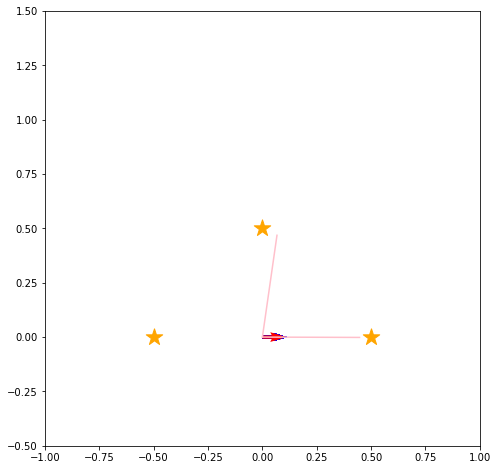

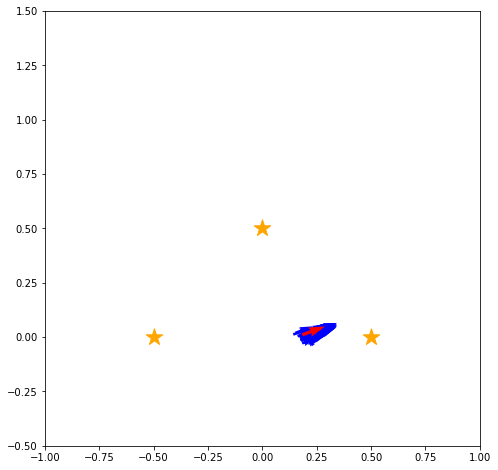

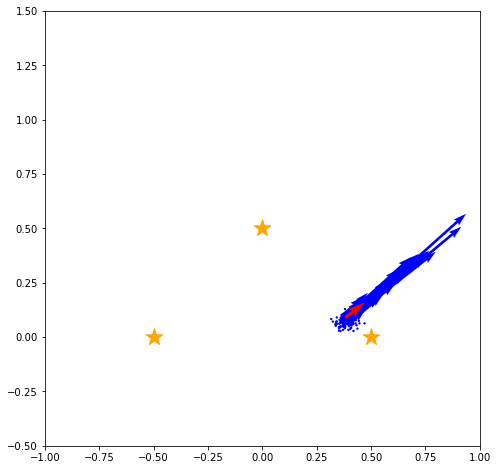

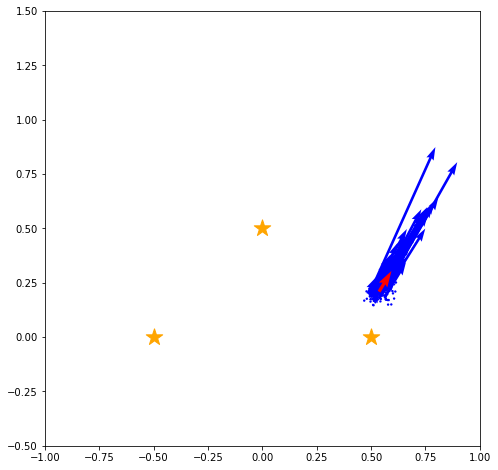

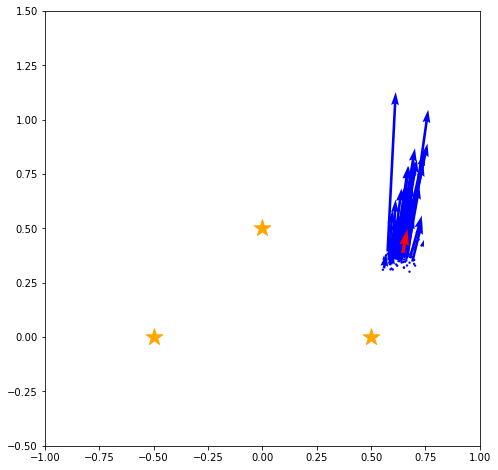

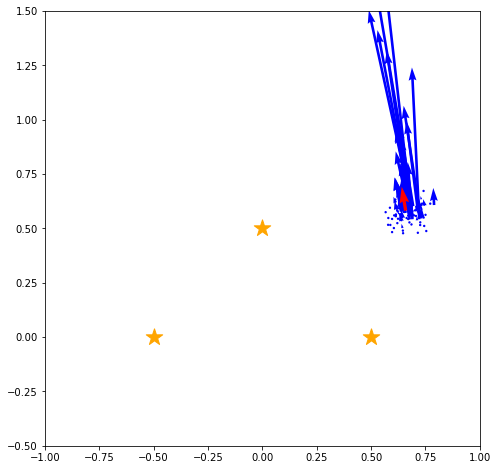

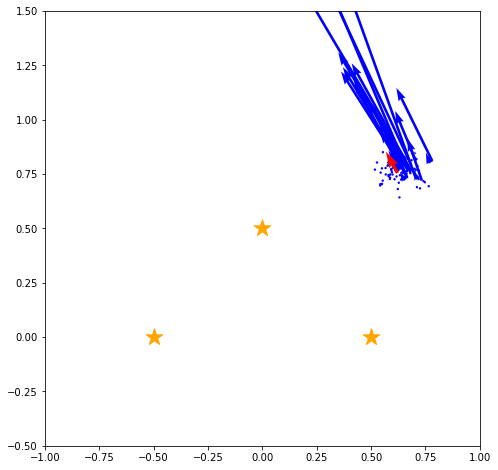

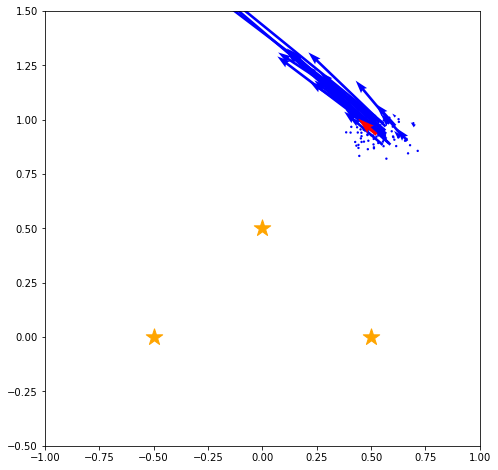

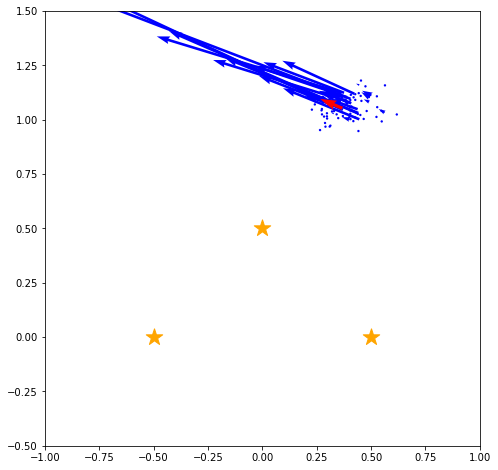

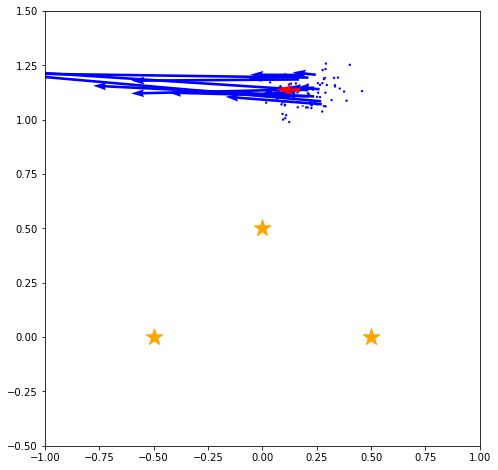

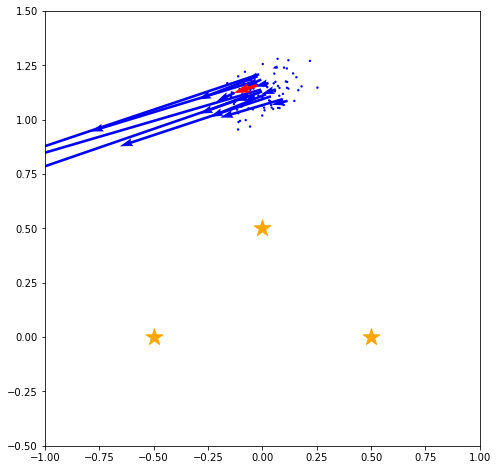

In [14]:
actual_x = np.array([0.0,0.0,0.0])
particles = [Particle(1.0/100) for i in range(100)]
u = np.array([0.2,math.pi / 180.0 * 20])

path = [actual_x]
particle_path = [copy.deepcopy(particles)]
measurementss = [observations(actual_x, actual_landmarks)]
for i in range(10):
    actual_x = f(actual_x,u)
    path.append(actual_x)
    ms = observations(actual_x,actual_landmarks)
    measurementss.append(ms)

    for p in particles:
        p.pose = f(p.pose,u)
    
    for m in ms:
        change_weights(particles, m)
    particle_path.append(copy.deepcopy(particles))

for i,p in enumerate(path):
    draw(path[i],particle_path[i])
    draw_landmarks(actual_landmarks)
    draw_observations(path[i],measurementss[i])

In [15]:
class Particle:
    def __init__(self,p,w ):
        self.pose = np.array(p)
        self.weight = w
    
    def __repr__(self):
        return "pose: " + str(self.pose) + " weight: " + str(self.weight)

In [16]:
for p in particles:
    print(p)

pose: [-0.13096081  1.07208744  3.57531318] weight: 4.7234386063e-09
pose: [ 0.04253227  1.0556812   3.56520943] weight: 1.86499396542e-07
pose: [ 0.03991363  1.08143728  3.55787095] weight: 1.47475006875e-05
pose: [-0.05845177  1.12681748  3.47165792] weight: 0.00200533231058
pose: [ 0.04969939  1.0488076   3.58257807] weight: 3.7956016371e-15
pose: [ 0.07160691  1.15487404  3.31549236] weight: 1.99094201051e-07
pose: [-0.11118329  1.02903625  3.53117172] weight: 1.12535326924e-13
pose: [ 0.16518642  1.13528518  3.35516885] weight: 8.50983290419e-10
pose: [-0.05098976  1.18069467  3.42769242] weight: 0.000347075170269
pose: [ 0.06215312  1.13906557  3.46189714] weight: 0.00629206372237
pose: [ 0.11956482  1.27318426  3.43178034] weight: 7.12831872087e-07
pose: [ 0.03515649  1.08535885  3.33593473] weight: 0.0
pose: [ 0.25308351  1.14713242  3.28477787] weight: 0.0
pose: [-0.0435619   1.17330041  3.43718536] weight: 0.0703640016
pose: [-0.03532897  1.11723841  3.47282162] weight: 0.115

In [17]:
accum = []
sm = 0.0
for p in particles:
    accum.append(p.weight + sm)
    sm += p.weight
    
print(accum)

[4.7234386062963495e-09, 1.9122283514870209e-07, 1.4938723522649509e-05, 0.0020202710341044889, 0.0020202710341082845, 0.0020204701283093357, 0.0020204701284218711, 0.0020204709794051615, 0.0023675461496737767, 0.0086596098720463748, 0.0086603227039184615, 0.0086603227039184615, 0.0086603227039184615, 0.079024324303925086, 0.1948754121736524, 0.1948754121736524, 0.1948754121736524, 0.20315045974886067, 0.20315149342622207, 0.20570894822205132, 0.2324976760236365, 0.23251946527442444, 0.29837061646938667, 0.30272288175383832, 0.30397725351703647, 0.30397725351705707, 0.3039772535170665, 0.30397770345734582, 0.30397770345813169, 0.30397835545991747, 0.30399257929778845, 0.30401983810279282, 0.32904527534555084, 0.33485969145156558, 0.33487790379237065, 0.74587641040538633, 0.74587915203142185, 0.74587916469393323, 0.7458791647031574, 0.74660612634337764, 0.74660612634337764, 0.74660614922830082, 0.74660614922830315, 0.74660614922830315, 0.74896536366062505, 0.7490899233514654, 0.75588202

In [18]:
pointer = random.uniform(0.0,1.0/len(particles))
print(pointer)

0.0075967273700074415


In [19]:
new_particles = []
particles_num = len(particles)

while pointer < 1.0:
    if accum[0] >= pointer:
        new_particles.append(
            Particle(copy.deepcopy(particles[0].pose),1.0/particles_num)
        )
        pointer += 1.0/particles_num
    else:
        accum.pop(0)
        particles.pop(0)

In [20]:
particles = new_particles

for p in particles:
    print(p)

pose: [ 0.06215312  1.13906557  3.46189714] weight: 0.01
pose: [-0.0435619   1.17330041  3.43718536] weight: 0.01
pose: [-0.0435619   1.17330041  3.43718536] weight: 0.01
pose: [-0.0435619   1.17330041  3.43718536] weight: 0.01
pose: [-0.0435619   1.17330041  3.43718536] weight: 0.01
pose: [-0.0435619   1.17330041  3.43718536] weight: 0.01
pose: [-0.0435619   1.17330041  3.43718536] weight: 0.01
pose: [-0.0435619   1.17330041  3.43718536] weight: 0.01
pose: [-0.03532897  1.11723841  3.47282162] weight: 0.01
pose: [-0.03532897  1.11723841  3.47282162] weight: 0.01
pose: [-0.03532897  1.11723841  3.47282162] weight: 0.01
pose: [-0.03532897  1.11723841  3.47282162] weight: 0.01
pose: [-0.03532897  1.11723841  3.47282162] weight: 0.01
pose: [-0.03532897  1.11723841  3.47282162] weight: 0.01
pose: [-0.03532897  1.11723841  3.47282162] weight: 0.01
pose: [-0.03532897  1.11723841  3.47282162] weight: 0.01
pose: [-0.03532897  1.11723841  3.47282162] weight: 0.01
pose: [-0.03532897  1.11723841 

In [21]:
path = [actual_x]
particle_path = [copy.deepcopy(particles)]
measurementss = [observations(actual_x, actual_landmarks)]
for i in range(10):
    actual_x = f(actual_x,u)
    path.append(actual_x)
    ms = observations(actual_x,actual_landmarks)
    measurementss.append(ms)

    for p in particles:
        p.pose = f(p.pose,u)
    
    for m in ms:
        change_weights(particles, m)
    particle_path.append(copy.deepcopy(particles))

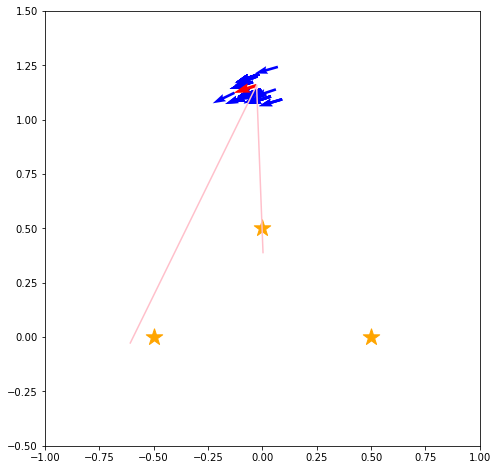

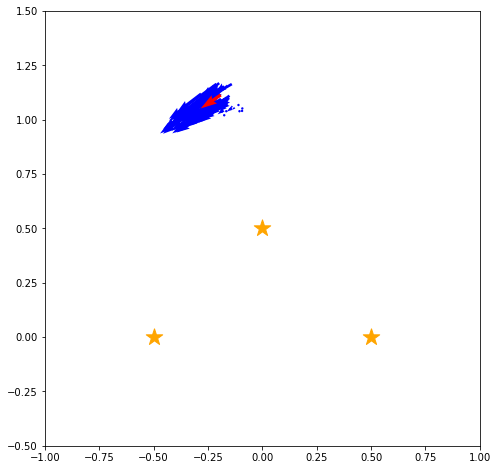

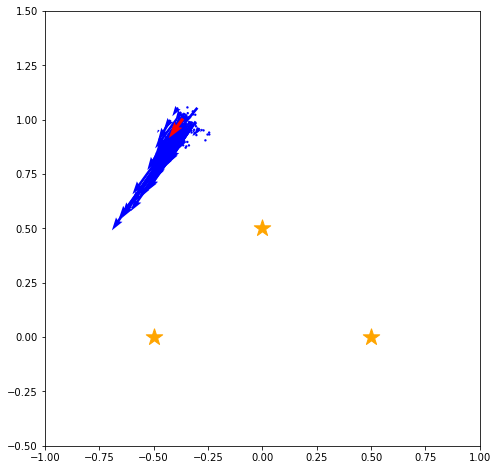

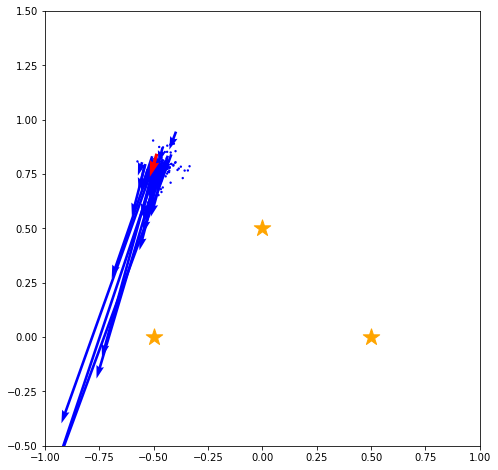

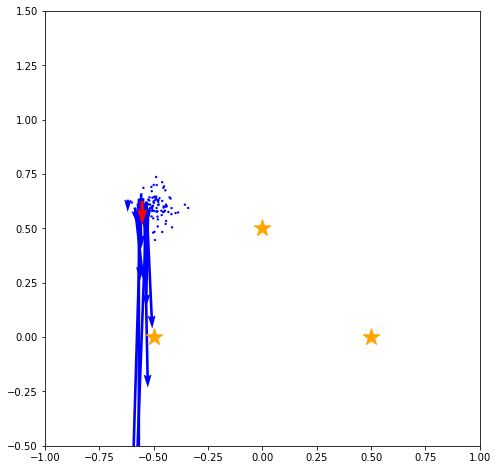

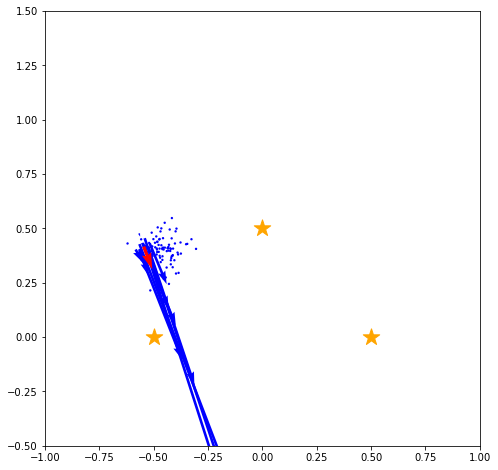

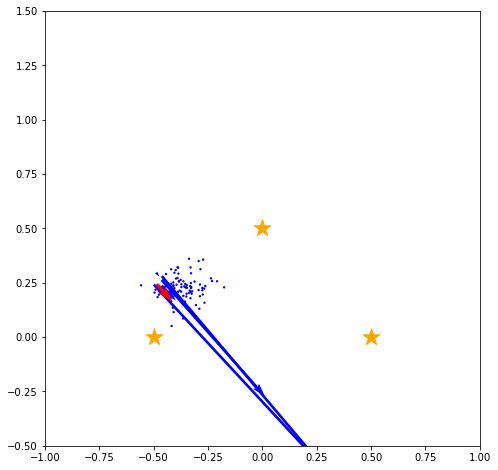

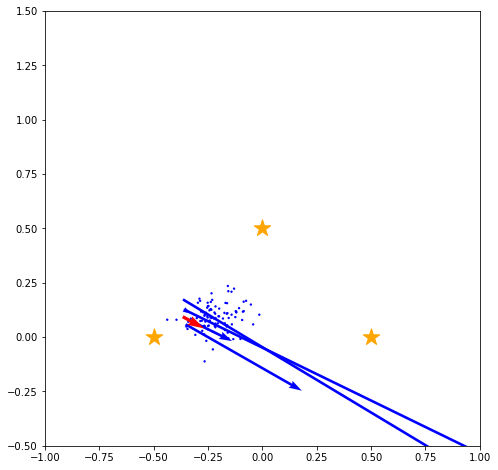

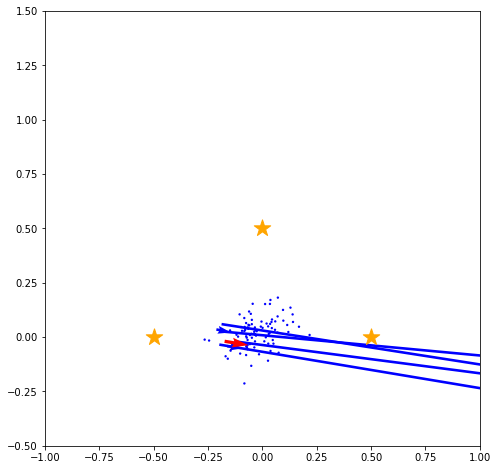

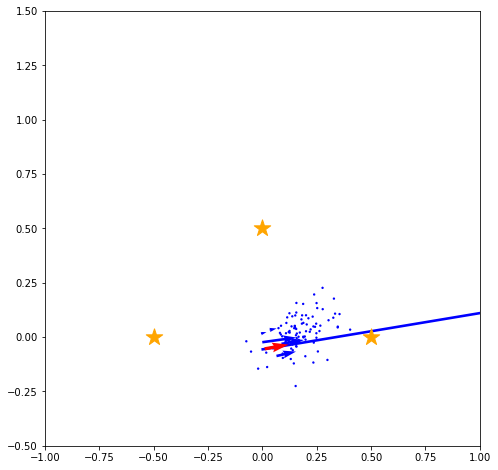

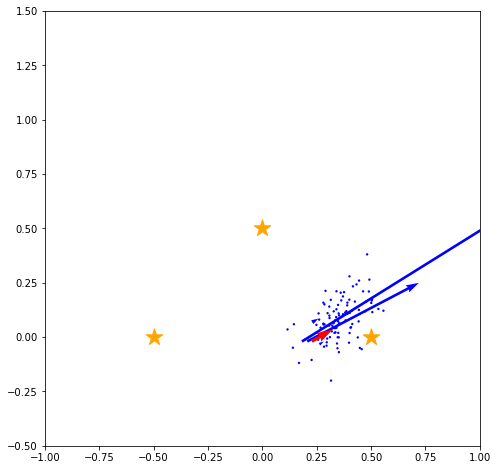

In [22]:
for i,p in enumerate(path):
    draw(path[i],particle_path[i])
    draw_landmarks(actual_landmarks)
    draw_observations(path[i],measurementss[i])